In [1]:
# Access to google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/My Drive

/content/drive/My Drive


In [0]:
import os
import random
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

In [0]:
with open('data.csv','r') as source:
  data = [(random.random(),line) for line in source]
  data.sort()

with open('shuffled_data.csv','w') as target:
  for _,line in data:
    target.write(line)

In [5]:
columns = ['bpm','rmssd','bsv','sdnn','state']
data = pd.read_csv('shuffled_data',names=columns)
print('Data shape:', data.shape)

Data shape: (1419, 5)


In [6]:
data.head(3)

,bpm,rmssd,bsv,sdnn,state
0,90.011620,21.472432,1.495668,38.651504,stress
1,76.012922,44.369812,1.510389,58.215515,stress
2,82.015897,18.358956,1.223427,30.733718,stress


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1419 entries, 0 to 1418
Data columns (total 5 columns):
bpm      1419 non-null float64
rmssd    1419 non-null float64
bsv      1419 non-null float64
sdnn     1419 non-null float64
state    1419 non-null object
dtypes: float64(4), object(1)
memory usage: 55.5+ KB


In [8]:
data.describe()

,bpm,rmssd,bsv,sdnn
count,1419.000000,1419.000000,1419.000000,1419.000000
mean,80.662481,37.946073,0.900984,44.989969
std,16.678008,19.512773,0.536415,20.081360
min,52.001664,13.731996,0.083158,15.409778
25%,70.002500,20.957492,0.483881,28.533881
50%,80.010854,29.974180,0.797426,40.463612
75%,88.018377,53.676676,1.221767,59.805320
max,126.032601,79.913276,3.309000,100.800470


In [9]:
data.isna().sum()

bpm      0
rmssd    0
bsv      0
sdnn     0
state    0
dtype: int64

In [0]:
features = data.drop('state',axis=1)
labels = data['state']
X = features
y = labels

Class repartition: 
 rest      783
stress    636
Name: state, dtype: int64


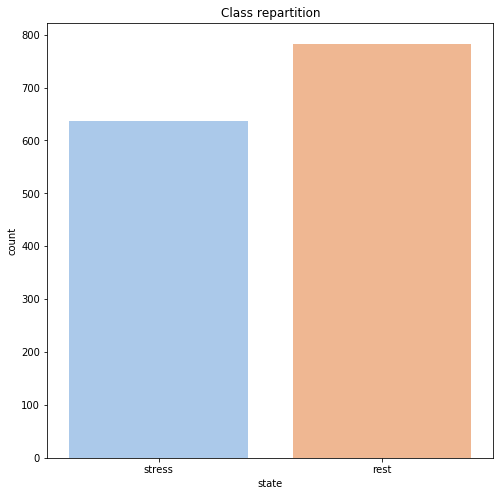

In [11]:
print('Class repartition: \n', data['state'].value_counts())
plt.figure(figsize=(8,8))
plt.title('Class repartition')
sns.countplot(data['state'],palette='pastel')

In [0]:
data['state'].replace(('stress','rest'),(0,1),inplace=True)

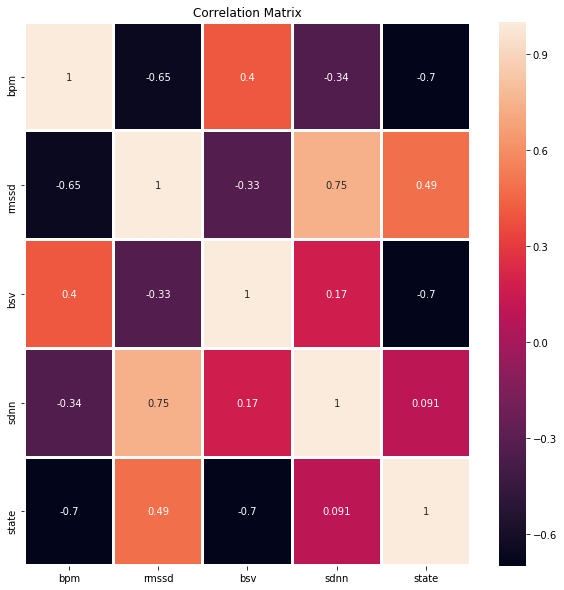

In [13]:
correlation = data.corr()

plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(correlation, annot=True, linewidths=2)

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


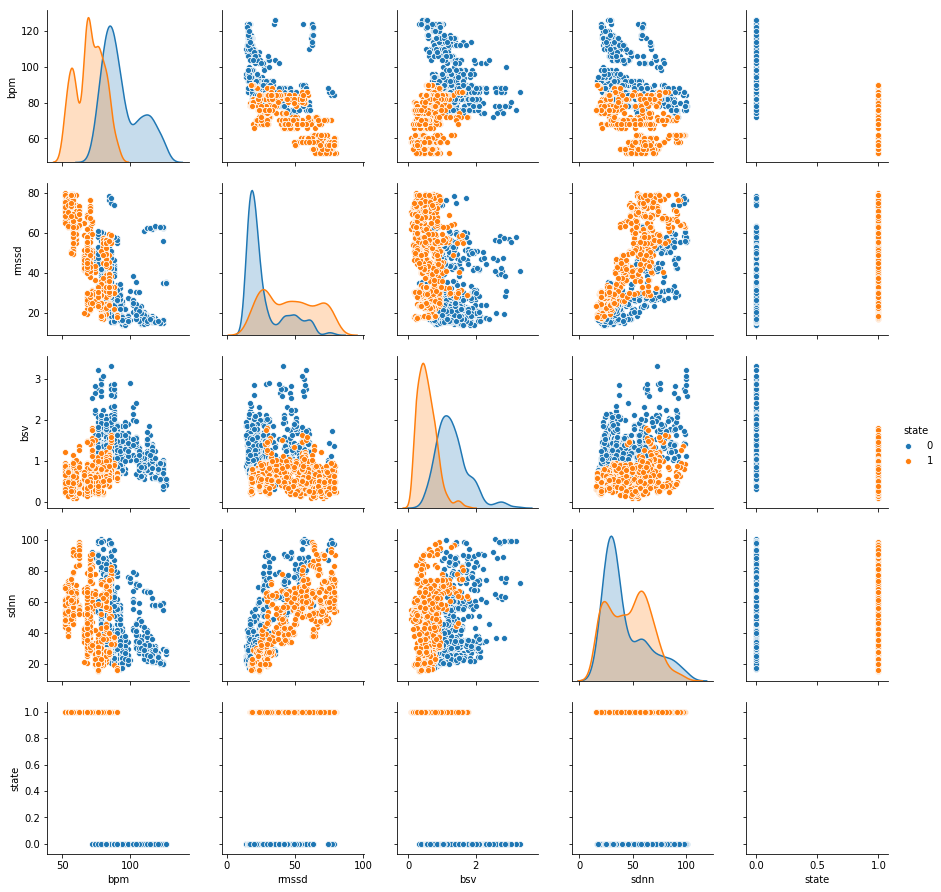

In [14]:
sns.pairplot(data,hue='state')

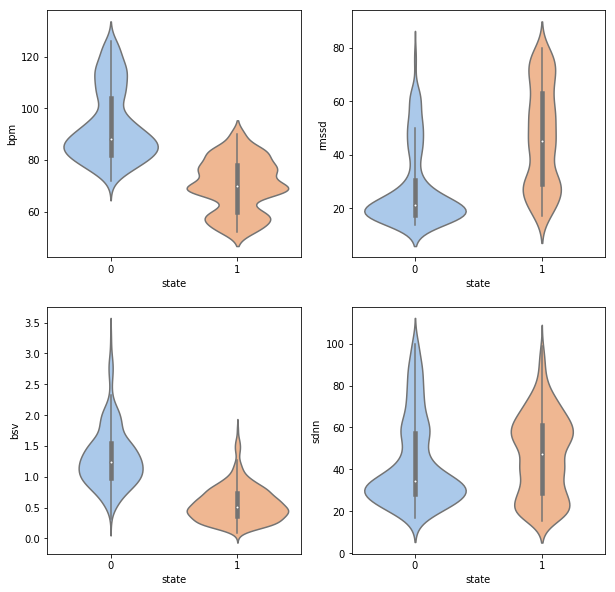

In [15]:
plt.figure(figsize=(10,10))

for ft,i in zip(features,range(1,5)):
  plt.subplot(2,2,i)
  sns.violinplot(x=data['state'], y=data[str(ft)],data=data,palette='pastel')
 

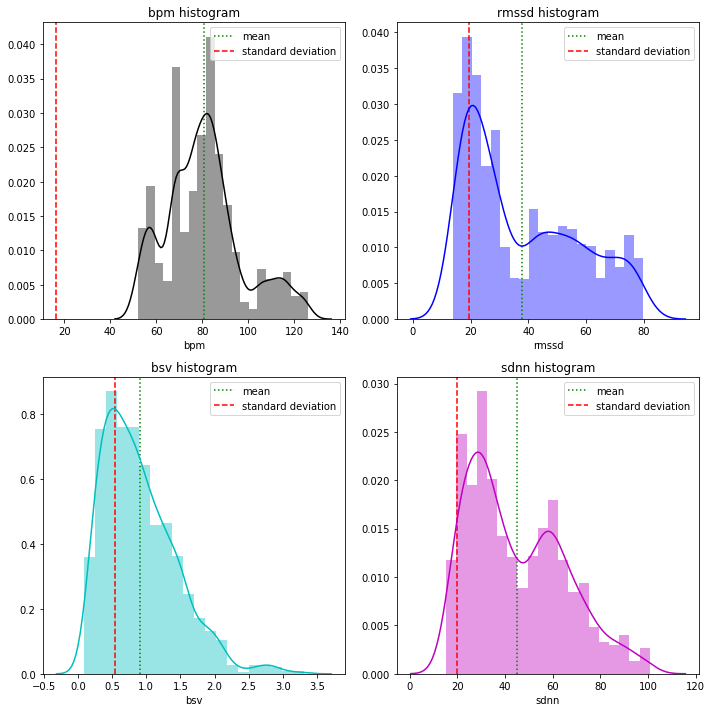

In [16]:
i = 1
color = ['k','b','c','m']

# Plot histogram for all features
plt.figure(figsize=(10,10))
for feature in features: 
 
  plt.subplot(2,2,i)
  plt.title(feature+' histogram')
  plt.axvline(data[str(feature)].mean(),linestyle='dotted', 
              color='g',label='mean')
  plt.axvline(data[str(feature)].std(),linestyle='dashed', 
              color='r',label='standard deviation')
  plt.legend(loc='best')
  sns.distplot(data[str(feature)], kde=True, bins=20,color=color[i-1])
  i+=1  
  
plt.tight_layout()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                                    test_size=0.2)

In [0]:
def eval_model(algo, m_type):

  print('---------------------------------------------------------------------')
  print('Model evaluation')
  print('---------------------------------------------------------------------')
  print(algo,'\n')
  
  # fit model
  algo.fit(X_train, y_train)
  accuracy = algo.score(X_test, y_test)
  scores = cross_val_score(algo, X_train, y_train, scoring='f1_macro', cv=5)
  print('Macro-F1 average: {0}'.format(scores.mean()))

  # Get prediction on test set
  y_pred = algo.predict(X_test)
  
  if m_type == 'coef':
    ft = algo.coef_.ravel()
   
  elif m_type == 'feature':
    ft = algo.feature_importances_
  
  
  # Get accuracy precision, recall & f1-score
  print('Accuracy:',accuracy)
  print('Classification report \n', classification_report(y_test, y_pred))
  
  # Confusion matrix
  plt.figure(figsize=(10,10))
  plt.subplot(321)
  plt.title('Confusion matrix')
  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, linewidths=2)
 

  # Get ROC curve & AUC
  plt.subplot(322)
  predict_proba = algo.predict_proba(X_test)[:,1]
  fpr, tpr, thresholds = roc_curve(y_test, predict_proba)
  plt.plot(fpr, tpr, label=('Area under the curve :', auc(fpr, tpr)),color='g')
  plt.plot([1,0],[1,0],linestyle = "dashed")

  plt.legend(loc='best')
  plt.title('Roc curve & area under curve')

  # Get feature importances graph
  if m_type == 'feature' or m_type == 'coef':
    
    df = pd.DataFrame(ft, X.columns).reset_index()
    df = df.rename(columns={'index':'features',0:'coef'})
    df = df.sort_values(by='coef')
    
    plt.subplot(323)
    plt.title('Feature importances')
    sns.barplot(x='coef', y='features', data=df)
    
  else :
    return algo  
  
  
  
  plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


---------------------------------------------------------------------
Model evaluation
---------------------------------------------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 

Macro-F1 average: 0.9751110152734341
Accuracy: 0.971830985915493
Classification report 
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       120
           1       0.97      0.98      0.98       164

   micro avg       0.97      0.97      0.97       284
   macro avg       0.97      0.97      0.97       284
weighted avg       0.97      0.97      0.97       284



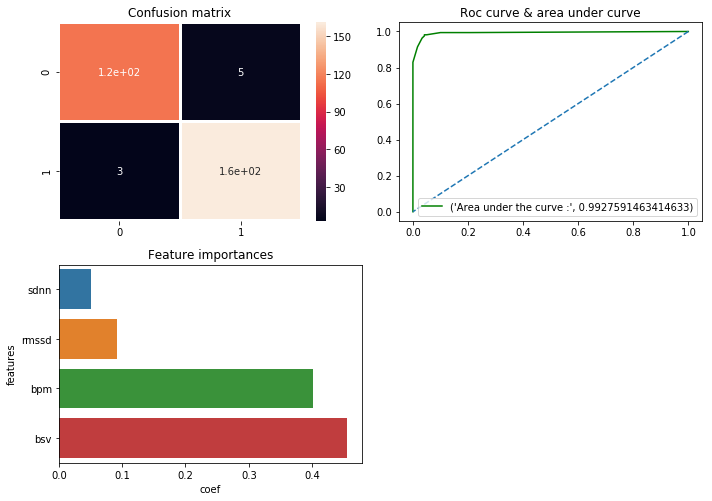

In [19]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
eval_model(rf, 'feature')

---------------------------------------------------------------------
Model evaluation
---------------------------------------------------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1) 

Macro-F1 average: 0.9751288651274708
Accuracy: 0.9788732394366197
Classification report 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       120
           1       0.98      0.98      0.98       164

   micro avg       0.98      0.98      0.98       284
   macro avg       0.98      0.98      0.98       284
weighted avg       0.98      0.98      0.98       284



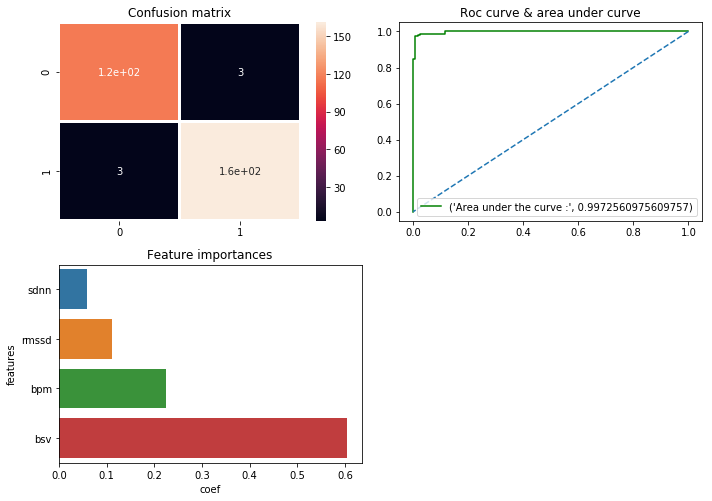

In [20]:
xgb = XGBClassifier()
eval_model(xgb, 'feature')


---------------------------------------------------------------------
Model evaluation
---------------------------------------------------------------------
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None) 

Macro-F1 average: 0.973351833982792
Accuracy: 0.9683098591549296
Classification report 
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       120
           1       0.97      0.98      0.97       164

   micro avg       0.97      0.97      0.97       284
   macro avg       0.97      0.97      0.97       284
weighted avg       0.97      0.97      0.97       284



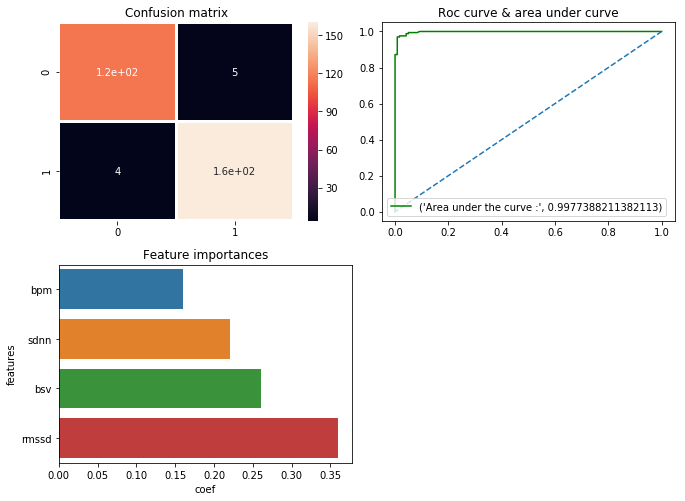

In [21]:
adaboost = AdaBoostClassifier()
eval_model(adaboost,'feature')

---------------------------------------------------------------------
Model evaluation
---------------------------------------------------------------------
GaussianNB(priors=None, var_smoothing=1e-09) 

Macro-F1 average: 0.9317916206093233
Accuracy: 0.9225352112676056
Classification report 
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       120
           1       0.93      0.94      0.93       164

   micro avg       0.92      0.92      0.92       284
   macro avg       0.92      0.92      0.92       284
weighted avg       0.92      0.92      0.92       284



GaussianNB(priors=None, var_smoothing=1e-09)

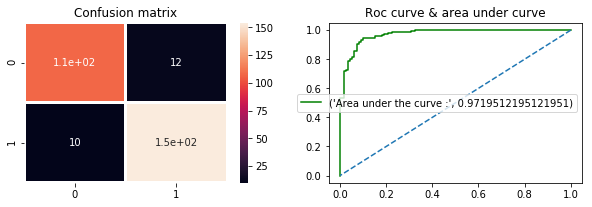

In [22]:
gnb = GaussianNB()
eval_model(gnb, 'none')

---------------------------------------------------------------------
Model evaluation
---------------------------------------------------------------------
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False) 

Macro-F1 average: 0.9759993334159383
Accuracy: 0.9788732394366197
Classification report 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       120
           1       0.98      0.99      0.98       164

   micro avg       0.98      0.98      0.9

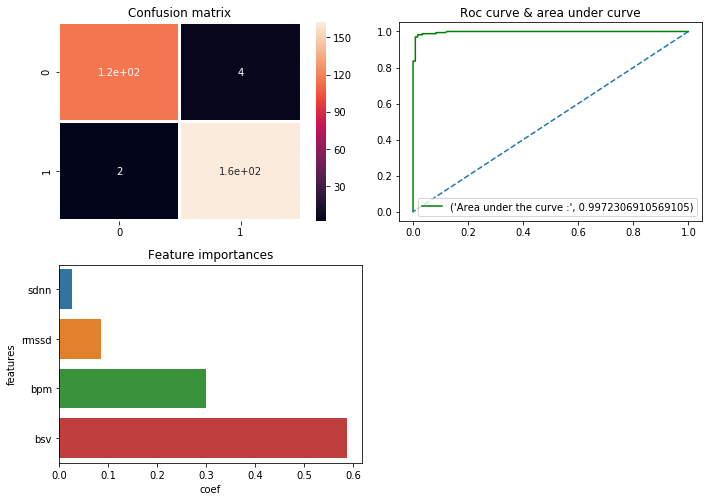

In [23]:
grad_boost = GradientBoostingClassifier()
eval_model(grad_boost, 'feature')

---------------------------------------------------------------------
Model evaluation
---------------------------------------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 

Macro-F1 average: 0.9172171944799192
Accuracy: 0.9190140845070423
Classification report 
               precision    recall  f1-score   support

           0       0.93      0.88      0.90       120
           1       0.91      0.95      0.93       164

   micro avg       0.92      0.92      0.92       284
   macro avg       0.92      0.91      0.92       284
weighted avg       0.92      0.92      0.92       284



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

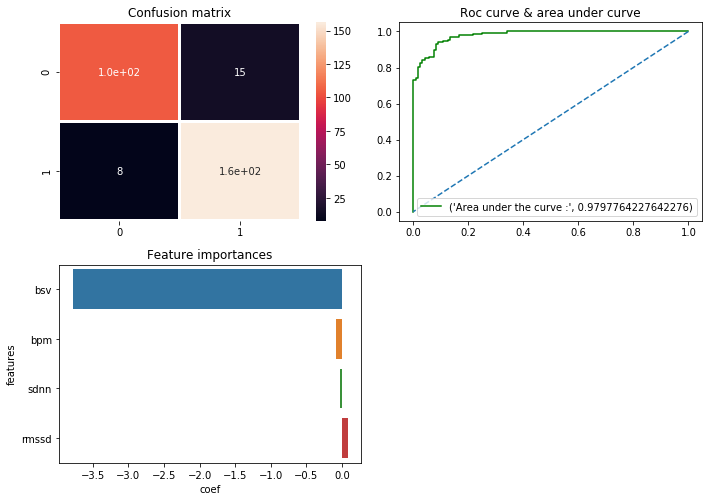

In [24]:
lr = LogisticRegression()
eval_model(lr, 'coef')

---------------------------------------------------------------------
Model evaluation
---------------------------------------------------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform') 

Macro-F1 average: 0.9751245523787764
Accuracy: 0.9859154929577465
Classification report 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       120
           1       1.00      0.98      0.99       164

   micro avg       0.99      0.99      0.99       284
   macro avg       0.98      0.99      0.99       284
weighted avg       0.99      0.99      0.99       284



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

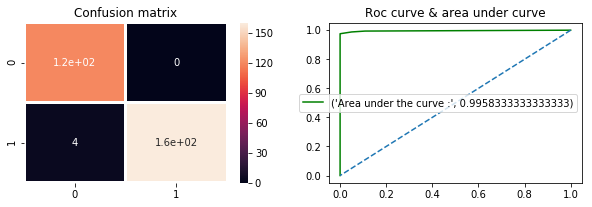

In [25]:
knn = KNeighborsClassifier()
eval_model(knn, 'none')